In [5]:
!pip install pandas numpy scipy matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



df = pd.read_csv("https://raw.githubusercontent.com/Rohanrathod7/my-ds-projects/main/08_stats_modeling/ab_test_web_conversion/Data/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
# Drop duplicates
df = df.drop_duplicates(subset='user_id')

# Check balance of groups
print(df['group'].value_counts())


group
treatment    145352
control      145232
Name: count, dtype: int64


       group  converted
0    control   0.120297
1  treatment   0.118843


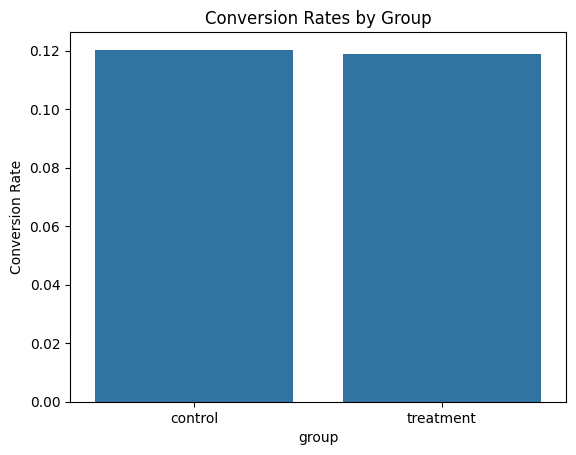

In [7]:
conversion_rates = df.groupby('group')['converted'].mean().reset_index()
print(conversion_rates)

sns.barplot(x='group', y='converted', data=conversion_rates)
plt.title('Conversion Rates by Group')
plt.ylabel('Conversion Rate')
plt.show()


**Hypothesis Testing (Two-Proportion Z-Test)**


H₀: Conversion rate of control = treatment

H₁: Conversion rate of treatment > control



In [8]:
# Counts
convert_A = df[df['group'] == 'control']['converted'].sum()
convert_B = df[df['group'] == 'treatment']['converted'].sum()

n_A = df[df['group'] == 'control'].shape[0]
n_B = df[df['group'] == 'treatment'].shape[0]

# Pooled proportion
p_pool = (convert_A + convert_B) / (n_A + n_B)

# Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_A + 1/n_B))

# Z-score
z = (convert_B/n_B - convert_A/n_A) / se

# One-tailed p-value
p_value = 1 - stats.norm.cdf(z)

alpha = 0.05
print(f"Z-score: {z:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("✅ Reject the null hypothesis: New page significantly improves conversions.")
else:
    print("❌ Fail to reject the null: No significant improvement.")


Z-score: -1.2084
P-value: 0.8866
❌ Fail to reject the null: No significant improvement.


In [9]:
diff = (convert_B/n_B) - (convert_A/n_A)
ci_low = diff - stats.norm.ppf(1 - alpha/2) * se
ci_high = diff + stats.norm.ppf(1 - alpha/2) * se

print(f"95% CI for difference: [{ci_low:.4f}, {ci_high:.4f}]")


95% CI for difference: [-0.0038, 0.0009]


**Sanity Checks Before Testing**

Industry best practice is to validate that your groups are properly randomized before trusting any test results.
We can check:

- Equal distribution of users between groups.

- Conversion rates before the experiment date are similar.

In [10]:
# Check group size balance
from scipy.stats import chi2_contingency

group_counts = df['group'].value_counts()
chi2, p, dof, ex = chi2_contingency([group_counts, [n_A/2, n_B/2]])
print(f"Randomization balance p-value: {p:.4f}")


Randomization balance p-value: 0.7996


**Effect Size Calculation (Cohen’s h)**  
Statistical significance ≠ business impact.  
We measure effect size to show how big the difference is.



In [11]:
import math

p1 = convert_A / n_A
p2 = convert_B / n_B
cohen_h = 2 * (math.asin(math.sqrt(p2)) - math.asin(math.sqrt(p1)))

print(f"Cohen's h: {cohen_h:.4f}")
if abs(cohen_h) < 0.2:
    print("Effect size: Small")
elif abs(cohen_h) < 0.5:
    print("Effect size: Medium")
else:
    print("Effect size: Large")


Cohen's h: -0.0045
Effect size: Small


**Bayesian A/B Testing**  
Instead of just saying "reject" or "fail to reject", we can compute posterior probability that B is better than A.

In [13]:
!pip install pymc3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 31.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 13.3 MB/s eta 0:00:00


In [17]:
import pymc as pm
import pytensor.tensor as tt

with pm.Model():
    p_A = pm.Beta('p_A', 1, 1)
    p_B = pm.Beta('p_B', 1, 1)

    obs_A = pm.Binomial('obs_A', n=n_A, p=p_A, observed=convert_A)
    obs_B = pm.Binomial('obs_B', n=n_B, p=p_B, observed=convert_B)

    trace = pm.sample(2000, cores=1, progressbar=False)

prob_B_better = (trace.posterior['p_B'] > trace.posterior['p_A']).mean()
print(f"Probability that B is better: {prob_B_better.item()*100:.2f}%")

Probability that B is better: 11.47%


**Power Analysis**  
Before even running the test, we can check if we had enough data to detect a meaningful change.

In [18]:
from statsmodels.stats.power import NormalIndPower

effect_size = NormalIndPower().solve_power(
    effect_size=0.02,  # expected lift
    power=0.8,
    alpha=0.05,
    ratio=n_B/n_A
)
print(f"Required sample size per group: {effect_size}")


Required sample size per group: 39228.10285105778


**Business Recommendation Dashboard**  
A small summary table with:

- Group conversion rates

- Difference & confidence interval

- P-value

- Effect size

- Bayesian probability

- Recommendation: “Ship” or “Don’t Ship”

In [19]:
summary = pd.DataFrame({
    "Group": ["Control (A)", "Treatment (B)"],
    "Conversion Rate": [p1, p2],
    "Difference": [np.nan, p2 - p1],
    "P-value": [np.nan, p_value],
    "Effect Size (Cohen's h)": [np.nan, cohen_h],
    "Bayesian Probability B > A": [np.nan, prob_B_better]
})
summary


,Group,Conversion Rate,Difference,P-value,Effect Size (Cohen's h),Bayesian Probability B > A
0,Control (A),0.120297,NaN,NaN,NaN,NaN
1,Treatment (B),0.118843,-0.001455,0.88655,-0.004483,<xarray.DataArray ()> Size: 8B\narray(0.11475)


**Optional Segmented Analysis**  
Sometimes, overall results hide subgroup effects (Simpson’s paradox).

Example: Check conversion rates by device type or country (if dataset has these columns).

In [20]:
if 'country' in df.columns:
    country_rates = df.groupby(['country', 'group'])['converted'].mean().unstack()
    print(country_rates)
